# Bayesian Statistical Inference
### Data Analysis in Astronomy / Physics
#### António Cesário, 201706207
#### Master's in Experimental Physics, FCUP

In [1]:
library('ggplot2')
library('pracma')
#library('pryr')
library('latex2exp')
library('adaptMCMC')
#memuse::Sys.meminfo()
# library("cubature")

Warning message:
"package 'latex2exp' was built under R version 4.0.5"
Warning message:
"package 'adaptMCMC' was built under R version 4.0.5"
Loading required package: parallel

Loading required package: coda

Warning message:
"package 'coda' was built under R version 4.0.5"
Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:pracma':

    expm, lu, tril, triu




In [2]:
# install.packages("rootSolve", repos="http://R-Forge.R-project.org")

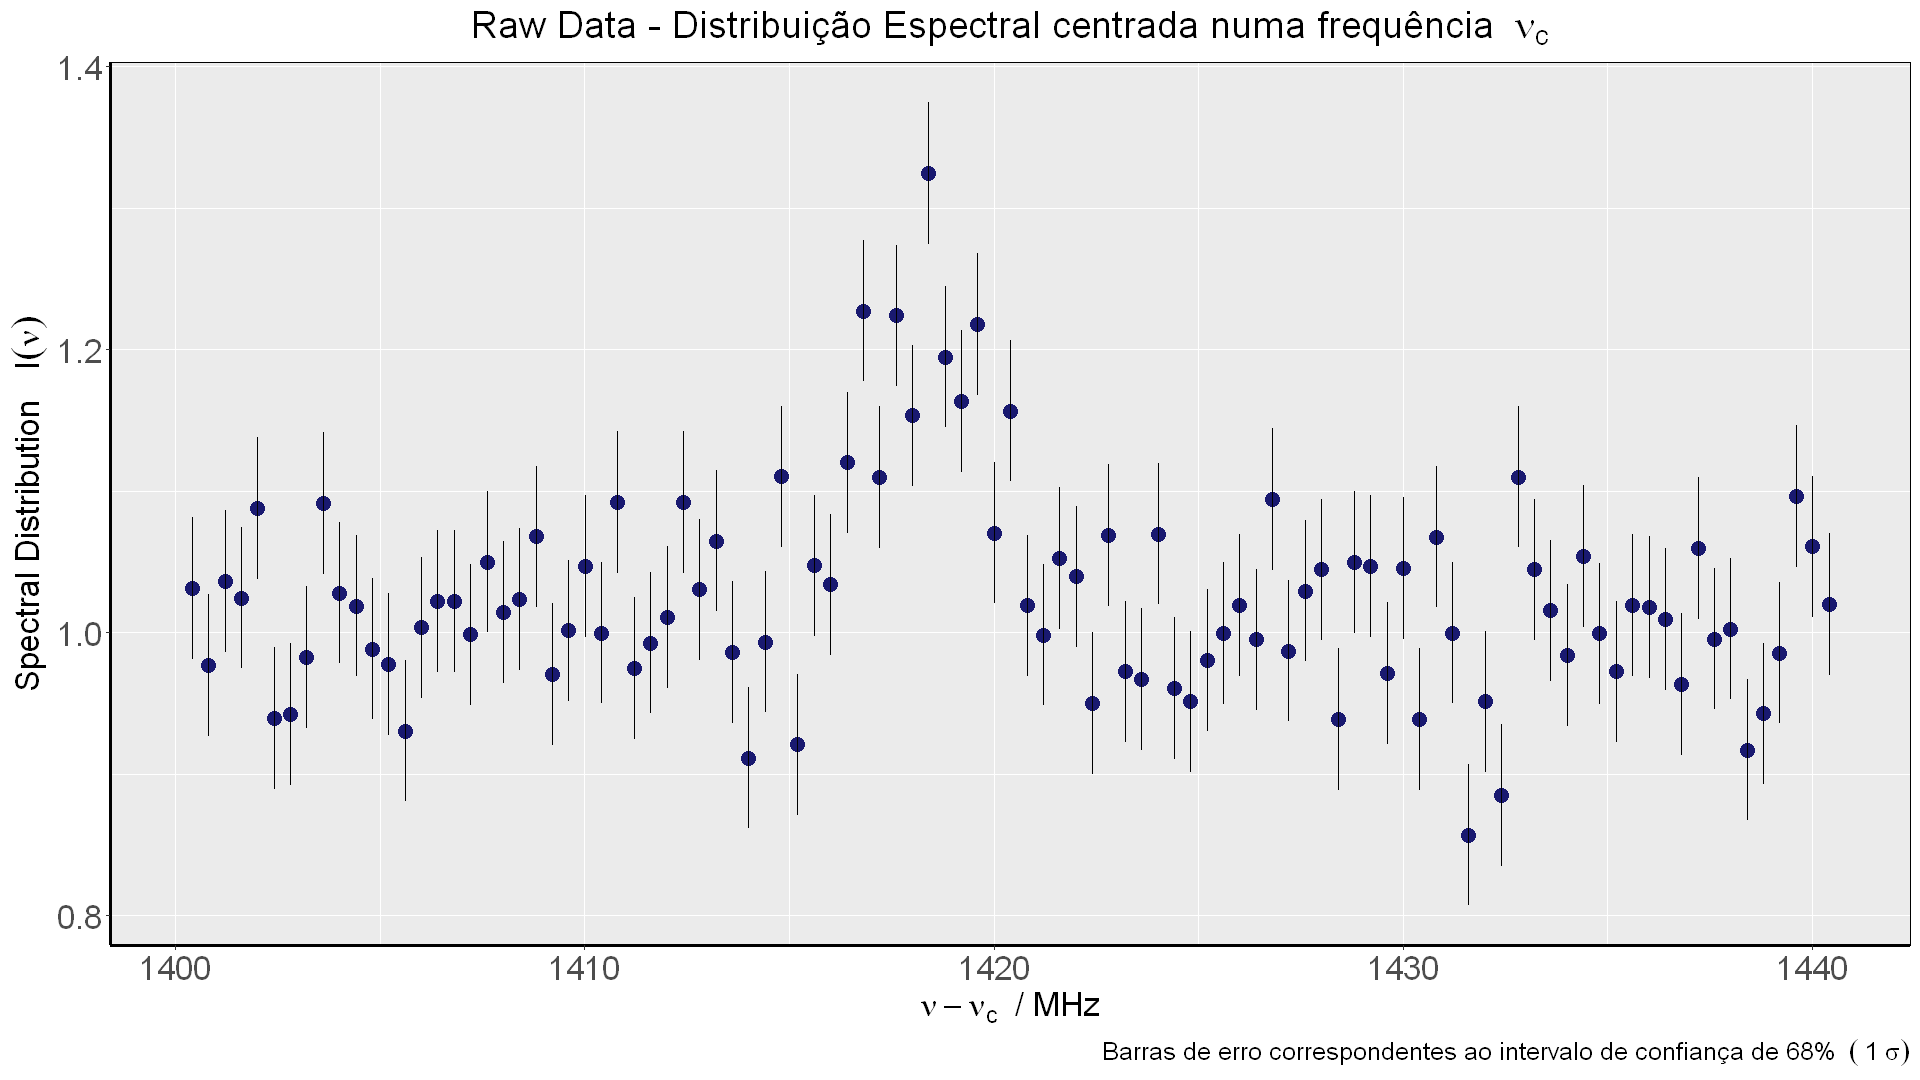

In [3]:
# Raw data visualization
options(repr.plot.width=16, repr.plot.height=9)
dados <- read.csv(file = 'data_Antonio.R',sep=' ', header=FALSE)
dados <- read.csv(file = 'data_Ana.R',sep=' ', header=FALSE)
names(dados) = c('freq','intensity') # change data.frame header's names
# plot( dados,
#       main = expression(paste('Raw Data - Distribuição Espectral centrada em ',nu[0])),
#       xlab = expression(paste(nu-nu[0],' / MHz')),
#       ylab = expression(paste('Spectral Distribution\t',  I(nu) ))
#       )

# ggplot theme to ease visualization in jupyter notebook documents
jupyter.theme <- function(base_size = 13, base_family = "", base_line_size = base_size/22, 
                         base_rect_size = base_size/22) {         
  theme( 
    plot.title = element_text(size=23,hjust = 0.5),
    axis.title = element_text(size = 20),                               
    axis.text.x = element_text(size = 20),                              
    axis.text.y = element_text(size = 20),                              
    plot.caption = element_text(size = 15, face = "italic"),            
    #panel.background = element_rect(fill="white"),                      
    axis.line = element_line(size = 1, colour = "black"),
    strip.background = element_rect(fill = "#cddcdd"),
    panel.border = element_rect(colour = "black", fill=NA, size=0.5),
        strip.text = element_text(colour = "black"),
        legend.key=element_blank()
  )
}

# actual plotting
ggplot( aes(x = freq, y = intensity), data = dados) +
    geom_point( size = 4 , colour = 'midnightblue' ) +
    xlab(bquote(nu-nu[c]~' / MHz')) +
    ylab(bquote('Spectral Distribution\t' ~ I(nu))) +
    labs(title = bquote('Raw Data - Distribuição Espectral centrada numa frequência '~nu[c]),
        caption = bquote('Barras de erro correspondentes ao intervalo de confiança de 68% '~(~'1'~sigma))) + 
    geom_linerange(aes(ymin = intensity -.05, ymax = intensity + .05)) + 
    jupyter.theme()

### $\mathcal{A}.2$ Cálculo de $p\left(g\mid G^+,D,I\right)$

$$
p\left(g \mid G^{+}, D, I\right) = \dfrac{p\left(g \mid G^+ , I\right)}{p\left(D \mid G^{+} ,I\right)} p\left( D \mid g , G^+, I\right)
$$

$$
\begin{align}
p\left( D \mid g , G^+, I\right) &\equiv \textrm{Likelihood de assumindo $g$ }\\
p\left(D \mid G^{+} ,I\right) &\equiv \textrm{Likelihood marginal/global (evidência) }\\
p\left(g \mid G^+ , I\right) &\equiv \textrm{Probabilidade prévia (prior)}
\end{align}
$$

## A. Question A

Queremos avaliar a existência de uma risca espectral na gama de frequências analisada experimentalmente. Para isso, foi proposta uma teoria em que a emissão é caracterizada pela seguinte equação

$$
\begin{align}
G(\nu) &= 1 \pm \frac{1}{g} \sqrt{\frac{\ln 2}{\pi}} \operatorname{exp}\left\{-\dfrac{\log 2\left(\nu-\nu_{0}\right)^{2}}{g^{2}}\right\}\\
+ &\equiv \textrm{a risca é de emissão}\\
- &\equiv \textrm{a risca é de absorção}
\end{align}
$$

onde $\nu_0$ (posição central do pico) e $g$ (1/2 da **FWHM**) são parâmetros livres da teoria. Propõem-se, portanto, os modelos 

$$
\begin{align}
G^0 &\equiv \textrm{distribuição uniforme na gama de frequências apresentada.}\\
G^+ &\equiv \textrm{emissão espectral caracterizada por $\nu_0$ e $g$.}
\end{align}
$$

Para testar qual destes modelos descreve melhor os dados obtidos, irei recorrer a uma análise Bayesiana dos mesmos, onde primeiro irei determinar o *Odds Ratio* entre os modelos $G_0$ e $G^+$ assumindo $g=2$, ao qual irei chamar

$$
G_2^+ \equiv \textrm{emissão espectral caracterizada por $\nu_0$ com $g=2$.}
$$

que apresenta apenas um parâmetro livre, a posição da risca espectral $\nu_0$.

### A.1 Cálculo de $\mathcal{O}_{0}^{2+}$

O *Odds Ratio* entre os modelos $G_2^+$ e $G^0$ é dado por

$$
\begin{aligned}
\mathcal{O}_{0}^{2+} &= \dfrac{p\left(G_2^{+} \mid D, I\right)}{p\left(G^{0} \mid D, I\right)} \\
&=\dfrac{p\left(G_2^{+} \mid I\right)}{p\left(G^{0} \mid I\right)} \cdot \dfrac{p\left(D \mid G_2^{+}, I\right)}{p\left(D \mid G^0, I\right)}
\end{aligned}
$$

onde identificamos os termos

$$
\begin{aligned}
\dfrac{p\left(G_2^{+} \mid I\right)}{p\left(G^{0} \mid \mathrm{I}\right)} &\equiv \textrm{razão entre priors}\\
\dfrac{p\left(D \mid G_2^{+}, I\right)}{p\left(D \mid G^0, I\right)} &\equiv \textrm{fator de Bayes}
\end{aligned}
$$

assumindo ignorância total sobre qual dos modelos caracteriza melhor os dados,

$$
\dfrac{p\left(G_2^{+} \mid I\right)}{p\left(G^{0} \mid I\right)} = 1
$$

logo

$$
\mathcal{O}_{0}^{2+} = \dfrac{p\left(D \mid G_2^{+}, I\right)}{p\left(D \mid G^0, I\right)} \quad \textrm{(fator de Bayes)}
$$

Se $\mathcal{O}_{0}^{2+} >> 1$ o modelo $G^+$ descreve os dados com maior verossemelhança. O oposto caso $\mathcal{O}_{0}^{2+} << 1$. O método para calcular os termos acima será apresentado mais adiante, na discussão da determinação da probabilidade pedida.

### A.2 Cálculo de $p\left( D \mid \nu_0 , G_2^+, I\right)$ - ( *Likelihood* do modelo $G_2^+$ assumindo $\nu_0$)

Admitindo que os resultados de cada medição são **independentes**, a probabilidade de obter os dados da experiência assumindo o modelo $G^+$ com $\nu_0 = \nu_0$ é dada por

$$
\begin{align}
p\left(D \mid G_2^{+}, \nu_{0}, I\right) &= \prod_{i=1}^{N} p\left(D_{i} \mid G_2^{+}, \nu_{0}, I\right)\\
    &= \prod_{i=1}^{N} p\left(E_{i} \mid G^{+}, \nu_{0}, I\right)
\end{align}
$$

$$
\begin{align}
p\left(D_{i} \mid G_2^{+}, \nu_{0}, I\right) &\equiv \textrm{probabilidade de obter o valor $d_i$ na medição $i$ de acordo com o modelo $G_2^{+}$ }\\
p\left(E_{i} \mid G_2^{+}, \nu_{0}, I\right) &\equiv \textrm{probabilidade de obter um erro de $e_i$ na medição $i$ de acordo com o modelo $G_2^{+}$ }
\end{align}
$$

O valor medido no bin $i$, $d_i$, é, à luz do modelo $G_2^+$, dado por

$$
\begin{align}
d_i &= f_i + e_i\\
f_i &= 1 + \frac{1}{g} \sqrt{\frac{\log 2}{\pi}} \operatorname{exp}\left\{-\dfrac{\log 2\left(\nu_i-\nu_{0}\right)^{2}}{g^{2}}\right\}
\end{align}
$$

onde $f_i$ é o valor previsto pelo modelo e $e_i$ o erro da medição. É-nos dito que o erro tem forma Gaussiana com um desvio padrão de $\sigma = 0.05 \textrm{ MHz}$ logo podemos escrever

$$
\begin{align}
p\left(E_{i} \mid G_2^{+}, \nu_{0}, I\right) &= \frac{1}{\sigma \sqrt{2 \pi}} \operatorname{exp}\left\{-\dfrac{e_{i}^{2}}{2 \sigma^{2}}\right\}\\
&= \dfrac{1}{\sigma \sqrt{2 \pi}} \operatorname{exp}\left\{-\dfrac{\left(d_i-f_i\right)^{2}}{2 \sigma^{2}}\right\}
\end{align}
$$

concluimos, portanto, que

$$
p\left(D \mid G_2^{+},\nu_0, I\right)=\frac{1}{\sigma^{N}(2 \pi)^{N / 2}} \exp\left\{-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(d_{i}-f_{i}\right)^{2}\right\}
$$

onde, mais uma vez, $d_i$ é o valor obtido no bin $i$ e $f_i$ o valor previsto pelo modelo $G_2^+$ para esse mesmo bin.

Para determinar a Likelihood global do modelo $G_2^+$, ***Marginal Likelihood***, precisamos de marginalizar a *Likelihood* acima nos seus parâmetros livres, neste caso em $\nu_0$. Voltaremos a este ponto depois de determinar a Likelihood de $G^0$.

#### A.2.1 Cálculo de $p\left( D \mid G^0, I\right)$ - (*Likelihood* do modelo $G^0$)

O modelo $G^0$ assume que o espectro obtido experimentalmente deve de ser constante $(=1)$ e não tem parâmetros livres. Assim, usando a mesma argumentação que na derivação da *Likelihood* anterior,

$$
d_i = 1 + e_i
$$

e portanto

$$
p\left(D \mid G^{0}, I\right)=\frac{1}{\sigma^{N}(2 \pi)^{N / 2}} \exp\left\{-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(d_{i}-1\right)^{2}\right\}
$$

### A.3 Cálculo de $p\left(D \mid G_2^{+}, I\right)$ - ( Likelihood Marginal de $G_2^+$ )

A *Likelihood* que queremos determinar nesta secção é dada por

$$
p\left(D \mid G_2^{+}, I\right)
    = \int \operatorname{d\nu_0} p \left(\nu_0 \mid G_2^{+}, I \right) p\left(D \mid \nu_0,G_2^{+}, I\right)\\
$$

#### A.3.1 Escolher $p \left(\nu_0 \mid G_2^{+}, I \right)$ - ( *prior* de $\nu_0$)

Para escolher a ***prior*** de $\nu_0$, $p \left(\nu_0 \mid G_2^{+}, I \right)$, primeiro reconhecemos que este termo se trata de um **parâmetro de localização** da distribuição, pelo que será aconselhado escolher

$$
p \left(\nu_0 \mid G_2^{+}, I \right) = \dfrac{1}{\Delta\nu}
$$

para impôr a condição da invariância de translação neste parâmetro. Como só nos é fornecida informação relativamente à gama de frequências estudada experimentalmente, irei assumir que o pico de emissão existe nesta mesma gama de frequências, ou seja,

$$
\begin{align}
\Delta \nu 
    &= \nu_{\textrm{Máximo medido}} - \nu_{\textrm{mínimo medido}}\\
    &= 1440.4 - 1400.4\\
    &= 40 \textrm{ MHz}
\end{align}
$$

Para além da invariância de translação, outra razão que me levou a escolher uma *prior* uniforme para este parâmetro, em vez de uma de Jeffreys, está relacionada com o facto de $\Delta\nu$ não se estender por várias ordens de grandeza, pelo contrário,

$$
\dfrac{\Delta\nu}{\nu_{min}} \approx 3 \%
$$

o que significa que o acréscimo de probabilidade para maiores valores de $\nu_0$ devido à *prior* uniforme será pequeno.
Com isto concluimos que 

$$
p\left(D \mid G_2^{+}, I\right)
    = \int \dfrac{\operatorname{d\nu_0}}{\Delta\nu} \frac{1}{\sigma^{N}(2 \pi)^{N / 2}} \exp\left\{-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(d_{i}-f_{i}\right)^{2}\right\}
$$

Com isto, estão estabelecidas as equações principais necessárias para realizar a análise de dados das alíneas A e B propostas. A discussão que se segue irá centrar-se mais no código e nos algoritmos utilizados para a concretização da análise.

### A.4 Determinar $p\left(D\mid G^+,I\right)$ - (*Likelihood* do modelo $G^+$)

Finalmente, para determinar a *Likelihood* global associada ao modelo $G^+$, temos que marginalizar $p\left(D\mid g, G^+,I\right)$ no parâmetro $g$, ou seja,

$$
\begin{align}
p\left(D \mid G^{+}, I\right)
    &= \int \operatorname{dg} p \left(g \mid G^{+}, I \right) p\left(D \mid g,G^{+}, I\right)\\
    &= \int \dfrac{\operatorname{dg}}{4\log\left(10\right)\cdot g}\left[
    \int \dfrac{\operatorname{d\nu_0}}{\Delta\nu} \frac{1}{\sigma^{N}(2 \pi)^{N / 2}} \exp\left\{-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(d_{i}-f_{i}\right)^{2}\right\}
    \right]
\end{align}
$$

Com isto, estão estabelecidas as equações principais necessárias para realizar a análise de dados desta questão. A discussão que se segue irá centrar-se mais no código e nos algoritmos utilizados para a concretização da análise.

In [4]:
# Defining Constants trhoughout the question
Nu.data <- dados[1]
G.data <- dados[2]

sigma <- 0.05
N <- 101

nu.min <- Nu.data$freq[1] # minimum value of \nu in data
nu.max <- tail(Nu.data$freq,n=1) # maximum of \nu in data
Delta.nu <- nu.max - nu.min # range of frequencies in data


# Likelihood - G0 hypothesis - Final Calculation
Likelihood_G.null <- function(){
    summation <- sum( (G.data - 1.)^2. ) * (- 0.5 / sigma^2. )
    
    exp(summation) / ( sqrt(2.*pi) * sigma ) ^ N
}

# Theoretical Emission Curve - G+ hypothesis 
emission_spec <- function(nu_0, g) {
    # nu_0 : free parameter, postion of the emission spectrum
    # g : free parameter, scale of the emission spectrum
    f1 <- exp( - log(2) * (Nu.data-nu_0)^2 / g^2 )
    1. + f1 * sqrt(log(2)/pi) / g
}

# Likelihood Function - Integral in \nu_0 Calculation
integrand_Likelihood_G.2plus <- function(nu_0,g=2){
    fi <- emission_spec( nu_0 , g )
    summation  <- sum( (G.data - fi)^2. ) * (- 0.5 / sigma^2.0 )
    
    exp(summation) / Delta.nu / ( sqrt(2.*pi) * sigma ) ^ N
}

# Likelihood Function - Integral in \nu_0 Calculation
integrand_mean_calc <- function(nu_0,g=2){
    fi <- emission_spec( nu_0 , g )
    summation  <- sum( (G.data - fi)^2. ) * (- 0.5 / sigma^2.0 )
    
    nu_0 * exp(summation) / Delta.nu / ( sqrt(2.*pi) * sigma ) ^ N
}

# # Marginal Likelihood - G2+ hypothesis - Integral Calculation
Likelihood_G.2plus <- function(){
    
    integrate(Vectorize(integrand_Likelihood_G.2plus ,vectorize.args='nu_0'),
              lower = nu.min,
              upper = nu.max,
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-4) # rel.tol = relative total numerical error of integration
}

# Marginal Likelihood - G+ hypothesis - Double Integral Calculation
Likelihood_G.plus <- function(){
    
    integral2(Vectorize(function(g,nu_0){
        
        1 / ( Delta.nu * ( g * log(g.max/g.min) ) * ( sqrt(2*pi) * sigma ) ^ N ) * # 1 / (...) * \\ exp(...)

        exp(sum(( G.data - 1 - exp(-log(2)*(Nu.data-nu_0)^2/g^2) * sqrt(log(2)/pi)/g) ^2) * (- 0.5 / sigma^2 )) 

        }), xmin=g.min, xmax=g.max, ymin=nu.min, ymax=nu.max)
    }

# Mean Value
calc_mean <- function(){
    
    integrate(Vectorize(integrand_mean_calc ,vectorize.args='nu_0'),
              lower = nu.min,
              upper = nu.max,
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-4)

}

### $\mathcal{A}$ Cálculo de $\mathcal{O}_{0}^{2+}$
Na célula acima estão implementadas as rotinas principais necessárias para avaliar as quantidades necessárias para o resto da alínea A.


In [5]:
# A.1 Odds Ratio
# (cell runtime: < 4s)
L.G0 = Likelihood_G.null()
L.G2p = Likelihood_G.2plus()

In [6]:
odds_ratio = format( L.G2p$value / L.G0 , scientific = TRUE , digits = 5 )
num_error = format( L.G2p$abs.error / L.G2p$value * 100 , scientific = TRUE , digits = 1 )

cat('Odds Ratio = ', odds_ratio)
cat('\nwith a numerical error of', num_error,'%')

Odds Ratio =  4.228e+28
with a numerical error of 3e-03 %

## B. Question B

Da célula anterior, concluimos com segurança que o modelo $G_2^+$ descreve os dados obtidos com muita maior verossemelhança que $G^0$. Estamos agora em condições de determinar a **probabilidade posterior** de cada $\nu_0$ à luz de $G_2^+$ tendo em conta os dados, ou seja, podemos determinar a *pdf (probability density function)* de $\nu_0$, que iremos usar para fazer a análise estatística do modelo escolhido.

$$
p\left(\nu_0 \mid G_2^{+}, D, I\right) = \dfrac{p\left(\nu_0 \mid G_2^+ , I\right)}{p\left(D \mid G_2^{+} ,I\right)} p\left( D \mid \nu_0, G_2^+, I\right)
$$

$$
\begin{align}
p\left(\nu_0 \mid G_2^{+}, D, I\right) &\equiv \textrm{Probabilidade posterior}\\
p\left( D \mid \nu_0, G_2^+, I\right) &\equiv \textrm{Likelihood de assumindo $\nu_0$ }\\
p\left(D \mid G_2^{+} ,I\right) &\equiv \textrm{Likelihood marginal/global (evidência) }\\
p\left(\nu_0 \mid G_2^+ , I\right) &\equiv \textrm{Probabilidade prévia (prior)}
\end{align}
$$

In [7]:
print('Checking if the functions are working properly')
nu0 = nu.min + Delta.nu/2

G2p.marginal = L.G2p$value
G2p.prior = 1 / Delta.nu
G2p.likelihood = integrand_Likelihood_G.2plus(nu0) * Delta.nu

G2p.posterior = G2p.prior * (G2p.likelihood/G2p.marginal)

G2p.posterior

[1] "Checking if the functions are working properly"


[1] 3.479007e-23

O próximo passo será representar graficamente a *pdf* obtida. Pretendo avaliar a função para cada frequência nos dados, ou seja, $\vec{\nu_0}$ tomará todas as frequências dos dados. Para vetorizar o cálculo de $p\left(\nu_0 \mid G_2^{+}, D, I\right)$, construí uma matriz $101\times101$ que contém as diferenças $\nu_i - \nu_0$ onde ao longo das linhas temos $\nu_0$ constante e $\nu$ ao longo das colunas. Isto pode ser facilmente conseguido com o código abaixo.

In [8]:
# # Example of pdf vectorization

# x = c(1:10) # array with all the \nu (data)
# y = c(1:10) # array with all the \nu_0 wehere we want to determine the pdf

# cat('x : ',x,'\n')
# cat('y : ',y,'\n\n')

# Mx = matrix( rep(x,each=10) ,nrow=10 ) # create a matrix of N stacked x arrays ( N = length(y))
# cat('Matrix 10x10 - x stacked ',' ')
# Mx

# Mx = sweep(Mx, MARGIN = 1, y, "-") # subtract y to each column of Mx (MARGIN = 1 says it's the columns that we want to operate)
# cat('\n\nMatrix 10x10 - after subtraction',' ')
# Mx

# rowSums(Mx) # We can also sum the values over every row, which will come in handy in a bit

In [9]:
# Likelihood calculation for every value of \nu_0
x  = Nu.data$freq
Nu.diffs = matrix(rep(x,each=101),nrow=101)
Nu.diffs = sweep(Nu.diffs, MARGIN = 1,x, "-")

G.data_matrix = matrix(rep(G.data$intensity,each=101),nrow=101)

# Theoretical Emission Curve - G+ hypothesis 
G.predicted_matrix <- function() {
    g = 2
    
    1. + exp( - log(2) * Nu.diffs^2 / g^2 ) * sqrt(log(2)/pi) / g
}

# Likelihood Function - Integral in \nu_0 Calculation
Likelihood_G2p_matrix <- function(){
    
    summation  <- rowSums( (G.data_matrix - G.predicted_matrix() )^2. ) * (- 0.5 / sigma^2.0 )
    
    exp(summation) / Delta.nu / ( sqrt(2.*pi) * sigma ) ^ N
}

# Posterior Probability - G2+
posterior_G2p <- function(){
    G2p.prior * ( Likelihood_G2p_matrix() / G2p.marginal )
}

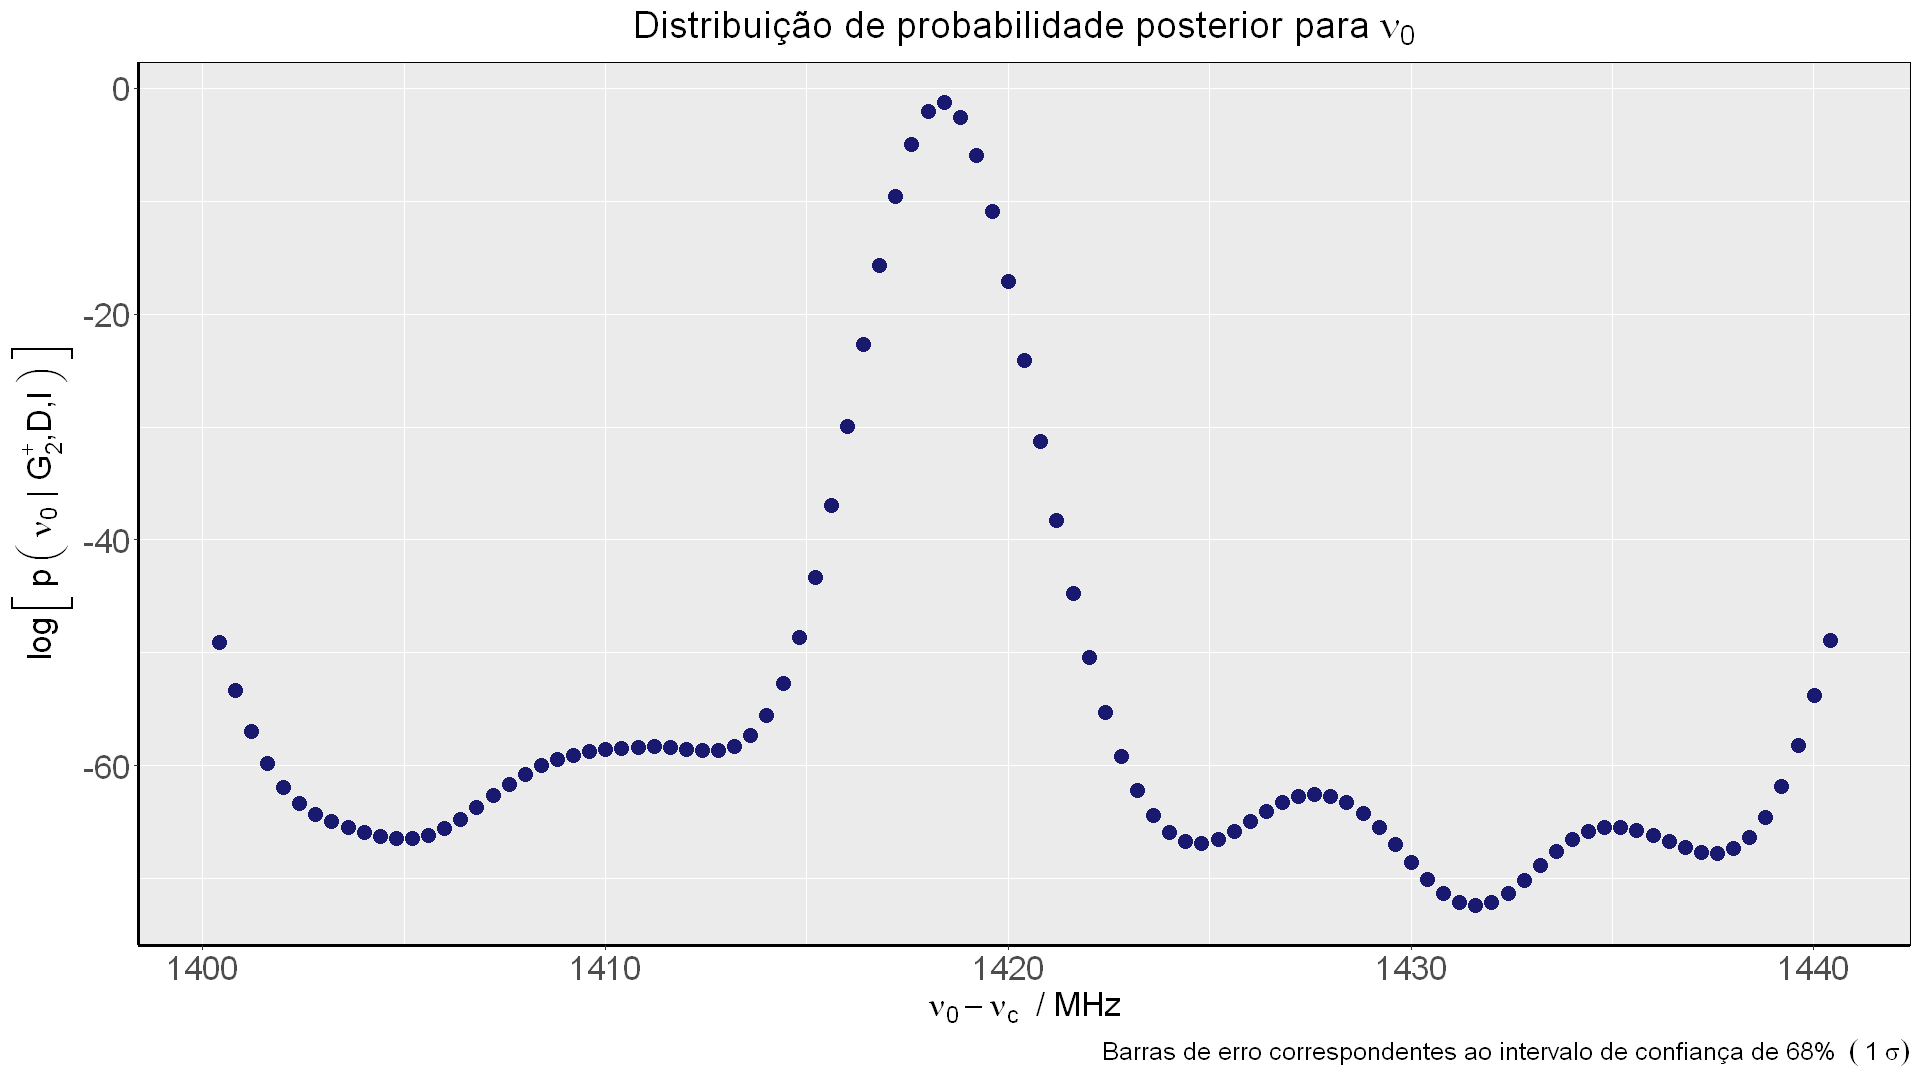

In [10]:
# Calculation of the pdf
G2p.posterior = posterior_G2p()

# Inserting the values into a dataframe
df.extended <- dados
df.extended$posterior <- G2p.posterior
df.extended$log10_posterior <- log(G2p.posterior,base=10)

# Plot of the above
ggplot(data = df.extended , aes(freq) ) +

    geom_point(aes(y=log10_posterior) , size = 4 , colour = 'midnightblue' )+
    
    labs(title = bquote('Distribuição de probabilidade posterior para'~nu[0]),
         caption = bquote('Barras de erro correspondentes ao intervalo de confiança de 68% '~(~'1'~sigma)),
         x = bquote(nu[0]-nu[c]~' / MHz'),
         y =  TeX(r'($log \, \left[ \, p\, \left(\, \nu_0 \, | \, G_2^{+}, D, I \,\right) \, \right]$)'),
         colour = 'Legend') +

    scale_color_manual(values = colors) +
    
jupyter.theme()

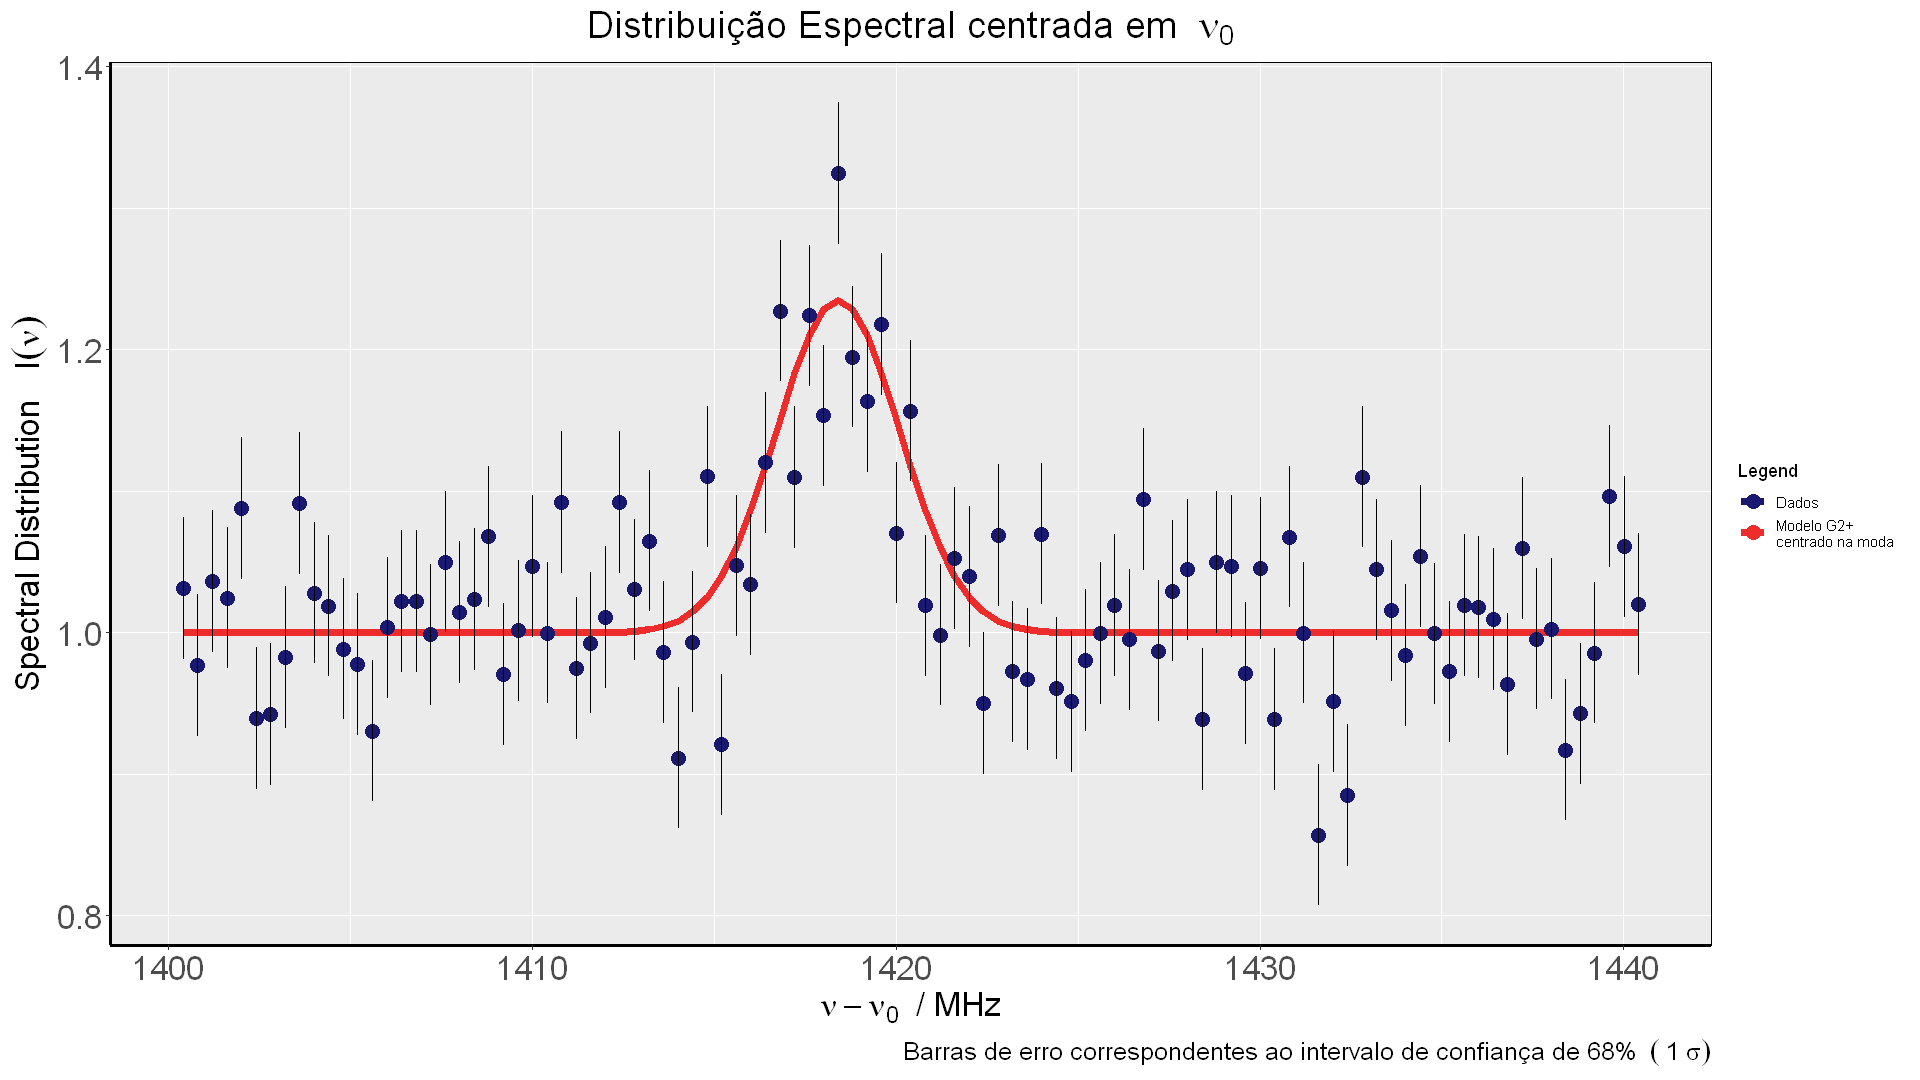

In [11]:
# Calculation of the theoretical emission curve at the most likely value of \nu_0

nu0_moda = Nu.data$freq[which.max(G2p.posterior)]
emission_curve = emission_spec(nu0_moda,g=2)$freq
df.extended$nu0_moda <- emission_curve

# Plot of the above
colors <- c("Dados" = 'midnightblue' , 'Modelo G2+\ncentrado na moda' = 'firebrick2')
ggplot(data = df.extended , aes(freq) ) +

    geom_line(aes(y=nu0_moda,colour='Modelo G2+\ncentrado na moda') , size = 2 )+
    
    geom_point( aes(y=intensity,colour = 'Dados') , size = 4 ) +
    geom_linerange(aes(ymin = intensity -.05, ymax = intensity + .05),colour='black') + # error bars

    
    labs(title = bquote('Distribuição Espectral centrada em '~nu[0]),
         caption = bquote('Barras de erro correspondentes ao intervalo de confiança de 68% '~(~'1'~sigma)),
         x = bquote(nu-nu[0]~' / MHz'),
         y = bquote('Spectral Distribution\t' ~ I(nu)),
         colour = 'Legend') +

    scale_color_manual(values = colors) +
    
jupyter.theme()

In [12]:
# Likelihood calculation for every value of \nu_0
x  = Nu.data$freq
Nu.diffs = matrix(rep(x,each=101),nrow=101)
Nu.diffs = sweep(Nu.diffs, MARGIN = 1,x, "-")

G.data_matrix = matrix(rep(G.data$intensity,each=101),nrow=101)

# Theoretical Emission Curve - G+ hypothesis 
G.predicted_matrix <- function() {
    g = 2
    
    1. + exp( - log(2) * Nu.diffs^2 / g^2 ) * sqrt(log(2)/pi) / g
}

# Likelihood Function - Integral in \nu_0 Calculation
Likelihood_G2p_matrix <- function(){
    
    summation  <- rowSums( (G.data_matrix - G.predicted_matrix() )^2. ) * (- 0.5 / sigma^2.0 )
    
    exp(summation) / Delta.nu / ( sqrt(2.*pi) * sigma ) ^ N
}

# Posterior Probability - G2+
posterior_G2p <- function(){
    G2p.prior * ( Likelihood_G2p_matrix() / G2p.marginal )
}

# Theoretical Emission Curve - G+ hypothesis 
emission_spec <- function(nu_0, g) {
    # nu_0 : free parameter, postion of the emission spectrum
    # g : free parameter, scale of the emission spectrum
    f1 <- exp( - log(2) * (Nu.data-nu_0)^2 / g^2 )
    1. + f1 * sqrt(log(2)/pi) / g
}

# Likelihood Function - Integral in \nu_0 Calculation
integrand_Likelihood_G.2plus <- function(nu_0,g=2){
    fi <- emission_spec( nu_0 , g )
    summation  <- sum( (G.data - fi)^2. ) * (- 0.5 / sigma^2.0 )
    
    exp(summation) / Delta.nu / ( sqrt(2.*pi) * sigma ) ^ N
}

# Likelihood Function - Integral in \nu_0 Calculation
integrand_mean_calc <- function(nu_0,g=2){
    fi <- emission_spec( nu_0 , g )
    summation  <- sum( (G.data - fi)^2. ) * (- 0.5 / sigma^2.0 )
    
    nu_0 * exp(summation) / Delta.nu / ( sqrt(2.*pi) * sigma ) ^ N
}

# Marginal Likelihood - G2+ hypothesis - Integral Calculation
Likelihood_G.2plus <- function(){
    
    integrate(Vectorize(integrand_Likelihood_G.2plus ,vectorize.args='nu_0'),
              lower = nu.min,
              upper = nu.max,
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-4) # rel.tol = relative total numerical error of integration
}

# pdf - to use in confidence limits calculation
pdf_G2p.cl <- function(nu.L,nu.U){
    
    integrate(Vectorize(integrand_Likelihood_G.2plus ,vectorize.args='nu_0'),
              lower = nu.L,
              upper = nu.U,
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-4) # rel.tol = relative total numerical error of integration
}

# Mean Value - just call function to determine the value
pdf_mean <- function(){
    
    I = integrate(Vectorize(integrand_mean_calc ,vectorize.args='nu_0'),
              lower = nu.min,
              upper = nu.max,
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-5)
    
    I$rel.error = I$abs.error / I$value
    I$abs.error = I$abs.error / G2p.marginal
    I$value = I$value / G2p.marginal
    
    head(I)

}

# Cumulative function
pdf_cum_simple <- function(y){
    
    integrate(Vectorize(integrand_Likelihood_G.2plus ,vectorize.args='nu_0'),
              lower = nu.min,
              upper = y, # <------------ we want to change this limit
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-4)

}

# Cumulative function - Vectorization of the upper limit - Used to plot Cum(nu_0)
pdf_cum <- function(nu){
    
    I = head(sapply(nu,pdf_cum_simple),2)
    
    values = array(as.numeric(unlist(I[1,])))
    abs.errors = array(as.numeric(unlist(I[2,])))
    rel.errors =  abs.errors / values
    values = values / G2p.marginal
    abs.errors = abs.errors / G2p.marginal
    log10.values = log(values,base=10)
    log.error.bars = rel.errors / log(10)
    
    data.frame(nu,values,abs.errors,rel.errors,log10.values,log.error.bars)
}

# Cumulative function - used for root finding
# the zero of this function gives us the median value of nu_0
pdf_cum_root <- function(y){
    
    I = integrate(Vectorize(integrand_Likelihood_G.2plus ,vectorize.args='nu_0'),
              lower = nu.min,
              upper = y, # <------------ we want to change this limit
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-4)$value
    
    log(I / G2p.marginal) + log(2)
}


# Marginal Likelihood - G2+ hypothesis - Integral Calculation
pdf_G2p <- function(nu){
    
    pdf.value = integrand_Likelihood_G.2plus(nu) / G2p.marginal
    log10.value = log(pdf.value,base=10)
    
    data.frame(pdf.value,log10.value)
}


# log(pdf) - differentiate to determine the higher Likelihood value (moda)
log.pdf_G2p <- function(nu){
    pdf.value = log( integrand_Likelihood_G.2plus(nu) / G2p.marginal , base = 10 )
}


# derivatve of log(pdf) - the root of this function will be the higher Likelihood value
# provided we give the proper interval
D_log.pdf_G2p <- function(nu){
    fderiv( Vectorize(log.pdf_G2p, vectorize.args='nu') , nu )
}



In [13]:
# Calculate the cumulative function at several data points
df.cum <- pdf_cum(Nu.data$freq[c(FALSE, TRUE, FALSE)])
head(df.cum)
# To save time c(FALSE, TRUE, FALSE) passes to the function only 1 value in every 3
# since we only want this to visualize how the C function varies with nu0

,nu,values,abs.errors,rel.errors,log10.values,log.error.bars
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1400.806,1.392858e-49,4.135497e-63,2.969073e-14,-48.85609,1.289452e-14
2,1402.006,1.392949e-49,2.633899e-56,1.890880e-07,-48.85606,8.211988e-08
3,1403.206,1.392949e-49,1.734256e-57,1.245025e-08,-48.85606,5.407074e-09
4,1404.406,1.392949e-49,1.717166e-54,1.232756e-05,-48.85606,5.353792e-06
5,1405.606,1.392949e-49,3.571588e-58,2.564049e-09,-48.85606,1.113552e-09
6,1406.806,1.392949e-49,2.633922e-56,1.890897e-07,-48.85606,8.212060e-08


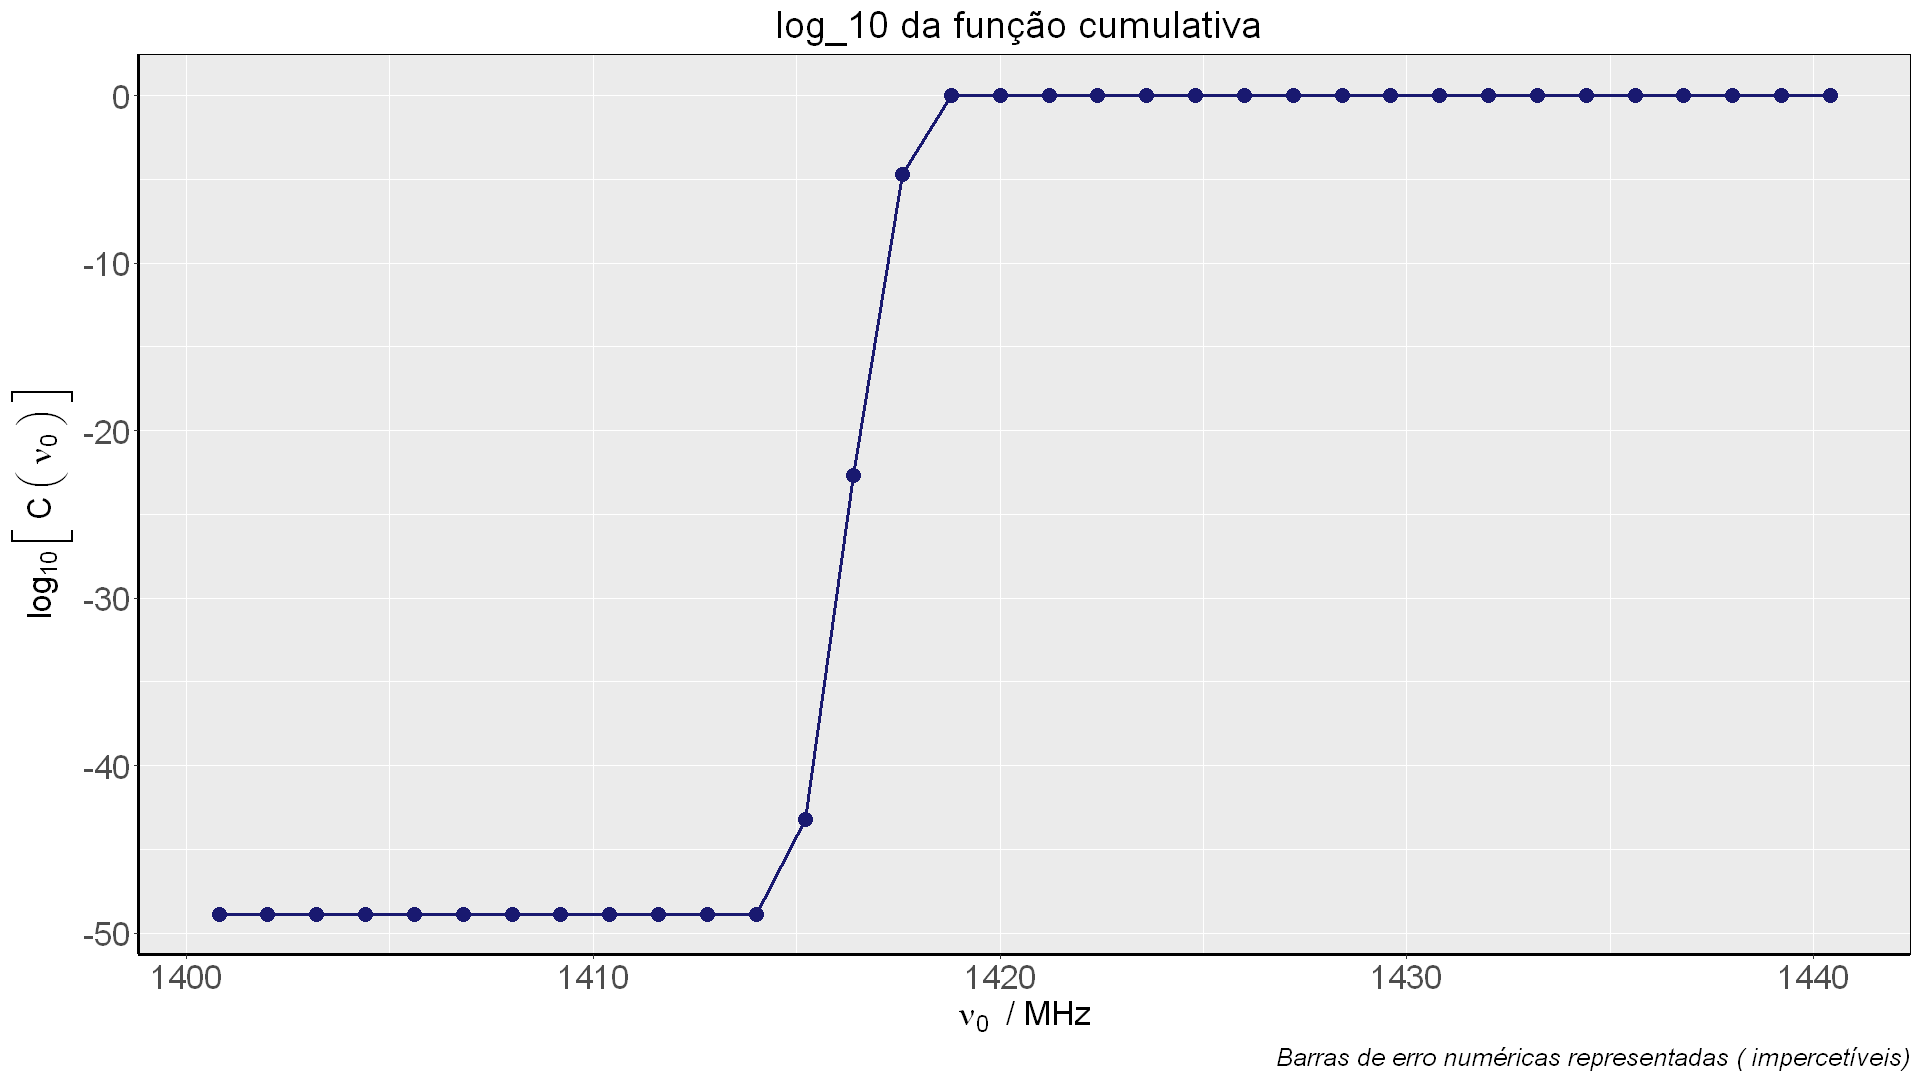

In [14]:
ggplot(data = df.cum , aes(nu) ) +
    
    geom_point( aes(y=log10.values) , size = 4 , colour = 'midnightblue') +
    geom_line( aes(y=log10.values) , size = 1 , colour = 'midnightblue')+

    geom_linerange(aes(ymin = log10.values - log.error.bars,
                       ymax = log10.values + log.error.bars), colour='black',size=2) + # error bars

    labs(title = bquote('log_10 da função cumulativa '),
         caption = bquote('Barras de erro numéricas representadas ( impercetíveis)'),
         x = bquote(nu[0]~' / MHz'),
         y =  TeX(r'($log_{10} \, \left[ \, C\, \left(\, \nu_0 \,\right) \, \right]$)')
         )+

    #scale_color_manual(values = colors) +
    
jupyter.theme()

In [15]:
# Calculate the cumulative function at a chosen range
cum_lim1 = 1415.006
cum_lim2 = 1420.006

df.cum2 <- pdf_cum(seq(cum_lim1,cum_lim2,by=0.4))

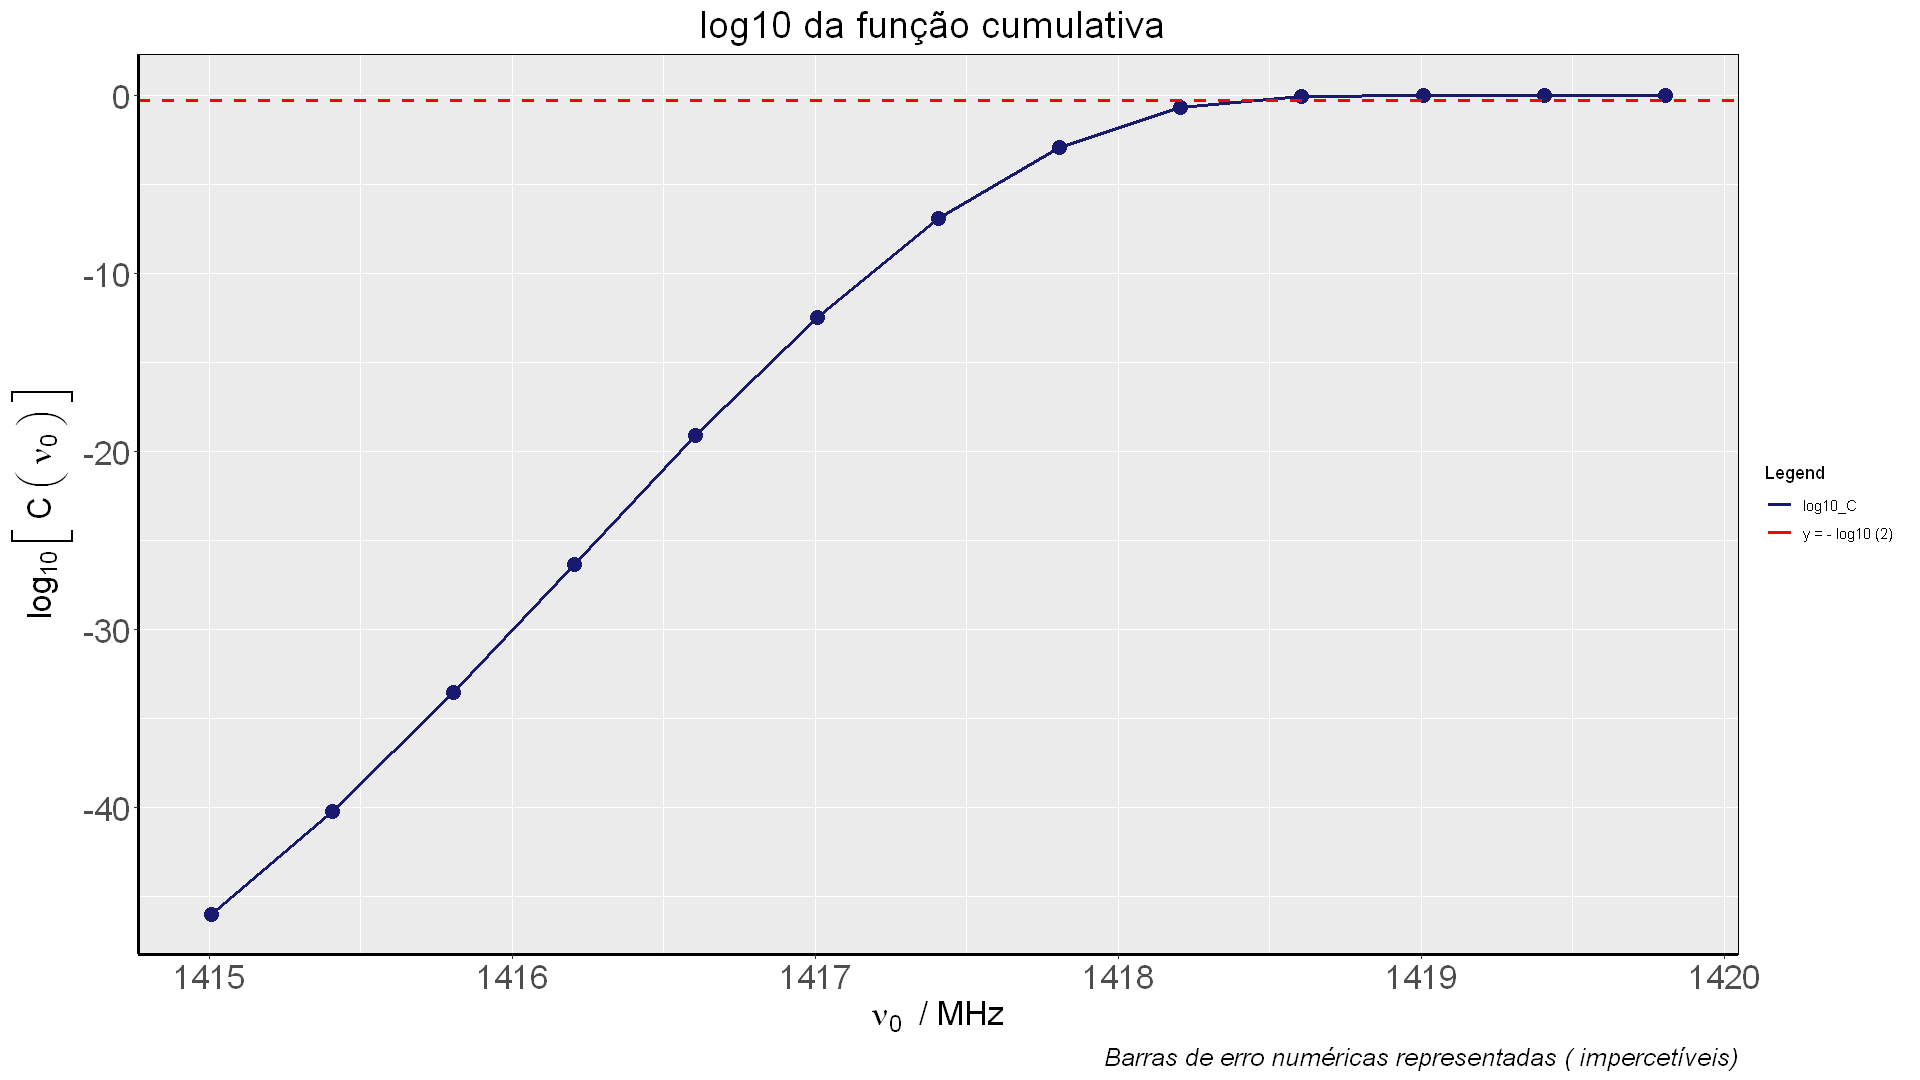

In [16]:
colors <- c("log10_C" = 'midnightblue' , 'y = - log10 (2)' = 'red')
ggplot(data = df.cum2 , aes(nu) ) +
    
    geom_point( aes(y=log10.values) , size = 4 , colour = 'midnightblue') +
    geom_line( aes(y=log10.values , colour = 'log10_C') , size = 1 )+
    
    geom_hline( aes(yintercept=-log(2,base=10),colour='y = - log10 (2)'), linetype="dashed", size=1) + 

    labs(title = bquote('log10 da função cumulativa '),
         caption = bquote('Barras de erro numéricas representadas ( impercetíveis)'),
         x = bquote(nu[0]~' / MHz'),
         y =  TeX(r'($log_{10} \, \left[ \, C\, \left(\, \nu_0 \,\right) \, \right]$)'),
         colour = 'Legend'
         )+

    scale_color_manual(values = colors) +
    
jupyter.theme()

In [17]:
# Moda - calculation
root.moda = uniroot(D_log.pdf_G2p,interval=c(cum_lim1,cum_lim2))
nu0_moda = root.moda$root
root.moda

$root
[1] 1418.355

$f.root
[1] -5.271834e-07

$iter
[1] 6

$init.it
[1] NA

$estim.prec
[1] 6.103516e-05

In [18]:
# Média - calculation
calc.mean = pdf_mean()
nu0_mean = calc.mean$value
calc.mean

$value
[1] 1418.356

$abs.error
[1] 1.239985e-05

$subdivisions
[1] 8

$message
[1] "OK"

$call
integrate(f = Vectorize(integrand_mean_calc, vectorize.args = "nu_0"), 
    lower = nu.min, upper = nu.max, g = 2, subdivisions = 100, 
    rel.tol = 1e-05)

$rel.error
[1] 8.742411e-09


In [19]:
# Mediana - calculation
cum_lim1  = 1415.006
cum_lim2 = 1420.006
root.mediana = uniroot(pdf_cum_root,interval=c(cum_lim1,cum_lim2))
nu0_mediana = root.mediana$root
root.mediana

$root
[1] 1418.356

$f.root
[1] -0.000112269

$iter
[1] 11

$init.it
[1] NA

$estim.prec
[1] 6.103516e-05

In [20]:
# ################################################################
# pdf - variable lower and upper limits - used to determine the 0.95 confidence levels
# ################################################################

pdf_G2p.cl <- function(nu.L,nu.U){
    
    I = integrate(Vectorize(integrand_Likelihood_G.2plus ,vectorize.args='nu_0'),
              lower = nu.L,
              upper = nu.U,
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-4) # rel.tol = relative total numerical error of integration
    
    I$value / G2p.marginal
}

# ################################################################
# Confidence Interval - Calculation
# ################################################################

# Guess upper and lower limits
# ( based on log(Likelihood) plot as well as considering it should be near nu_mean and nu_moda )
nu0_clL  = 1415.006
nu0_clU = 1420.006
step = 0.1

# Wanted confidence level
CL = 0.95

# Interval considered
interval = seq(nu0_clL, nu0_clU, by = step )
n = length(interval)

# Interval to dataframe
interval1 = interval[1:(n-1)]
df.cl = data.frame(interval1)

# array to save integrals (areas)
areas = vector(mode="numeric", length=(n-1))

# Integrating through successive point in the interval
for (i in 1:(n-1)){
    
    areas[i] = pdf_G2p.cl(interval[i],interval[i+1])
    
}

# Order areas in descending order
df.cl$areas = areas
df.cl = df.cl[order(df.cl$areas,decreasing = TRUE),]

# Create vector with cumulative sum of ordered areas
df.cl$areas.cumsum = cumsum(df.cl$areas)

# Check indexes where cumulative sum < CL
pass_indexes = sum(df.cl$areas.cumsum < CL) + 1 # +1 to include the first value that doesn't obey < CL
df.cl = df.cl[1:pass_indexes,]

# Check how far the obtained CL is from the objective
CL.diff = abs( df.cl[pass_indexes-1,3] - CL )

# Finally, get the upper and lower limits
nu0_clL = min(df.cl$interval)
nu0_clU = max(df.cl$interval) + step

# ################################################################
# print results
# ################################################################
cat(CL*100,'% Confidence Interval = [ ',nu0_clL,' , ' , nu0_clU,' ]\n\n' )

CL.diff.str = format(CL.diff/CL*100,scientific = FALSE , digits = 2 )
cat('[ CL obtido - 0.95 ] / CL obtido = ',CL.diff.str,'%')

95 % Confidence Interval = [  1417.906  ,  1418.706  ]

[ CL obtido - 0.95 ] / CL obtido =  0.34 %

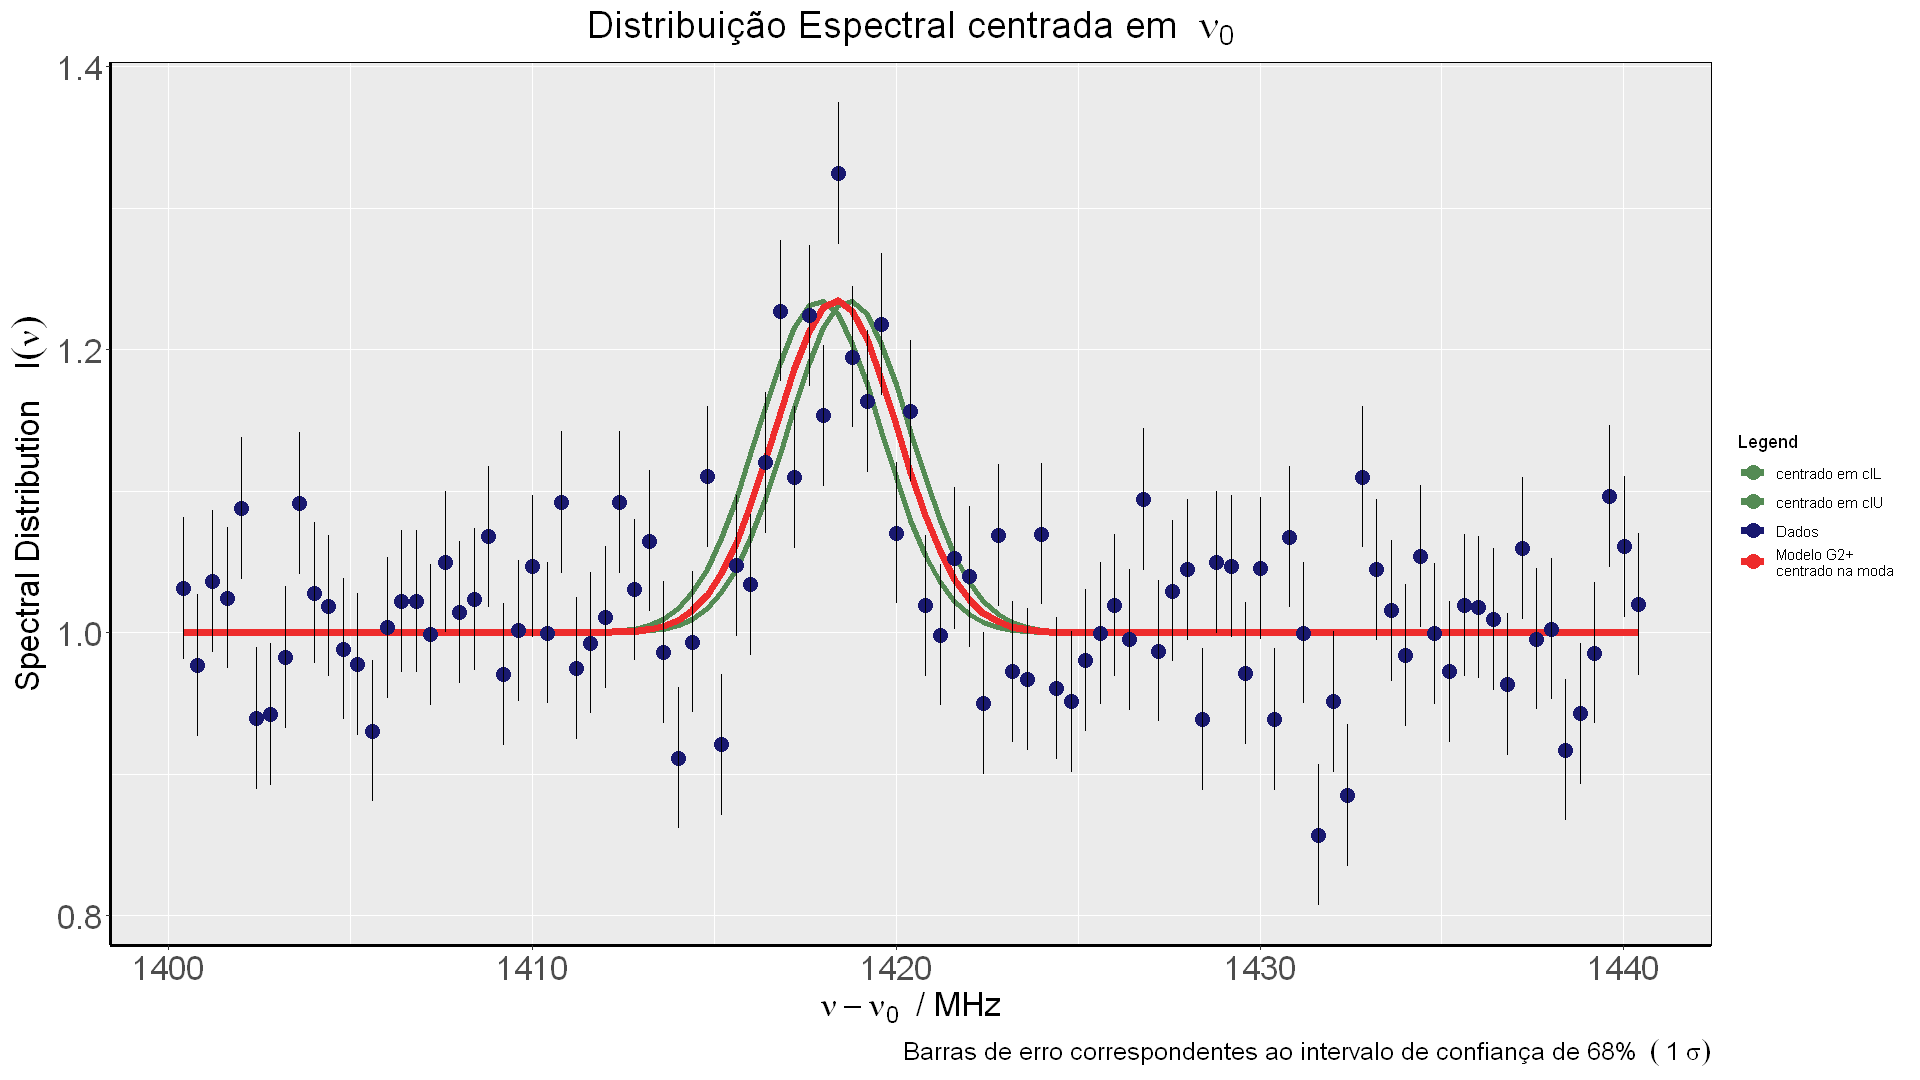

In [21]:
# Calculation of the theoretical emission curve at the most likely value of \nu_0


moda_emission_curve = emission_spec(nu0_moda,g=2)$freq
mean_emission_curve = emission_spec(nu0_mean,g=2)$freq
clL_emission_curve = emission_spec(nu0_clL,g=2)$freq
clU_emission_curve = emission_spec(nu0_clU,g=2)$freq

df.extended$nu0_moda <- moda_emission_curve
df.extended$nu0_clL <- clL_emission_curve
df.extended$nu0_clU <- clU_emission_curve

# Plot of the above
colors <- c("Dados" = 'midnightblue',
            'Modelo G2+\ncentrado na moda' = 'firebrick2',
            'centrado em clL' = 'palegreen4',
            'centrado em clU' = 'palegreen4'
           )
ggplot(data = df.extended , aes(freq) ) +

    geom_line(aes(y=nu0_clL,colour='centrado em clL') , size = 1.5 )+
    geom_line(aes(y=nu0_clU,colour='centrado em clU') , size = 1.5 )+
    geom_line(aes(y=nu0_moda,colour='Modelo G2+\ncentrado na moda') , size = 2 )+
    
    geom_point( aes(y=intensity,colour = 'Dados') , size = 4 ) +
    geom_linerange(aes(ymin = intensity -.05, ymax = intensity + .05),colour='black') + # error bars

    
    labs(title = bquote('Distribuição Espectral centrada em '~nu[0]),
         caption = bquote('Barras de erro correspondentes ao intervalo de confiança de 68% '~(~'1'~sigma)),
         x = bquote(nu-nu[0]~' / MHz'),
         y = bquote('Spectral Distribution\t' ~ I(nu)),
         colour = 'Legend') +

    scale_color_manual(values = colors) +
    
jupyter.theme()

## C. Questão C

In [34]:
dnu = Nu.data$freq[2]-Nu.data$freq[1]
g.min = dnu/2
g.max = sqrt(log(2)/pi)/sigma
Delta.g = g.max - g.min

nu_i = Nu.data$freq
d_i = G.data$intensity
S_1 = sum((d_i-1)^2)

# #############################################################################

f_i <- function(nu,g){
    
    exp(-log(2)*(nu_i-nu)^2/g^2) * sqrt(log(2)/pi) / g
    
}

# #############################################################################

r.ratio <- function(t_nu,q_nu,t_g,q_g){
    
    if ( (g.min < q_g) & (q_g < g.max) & (nu.min < q_nu) & (q_nu < nu.max)){
        
        t_fi = f_i(t_nu,t_g)
        q_fi = f_i(q_nu,q_g)

        summation = sum( ( q_fi^2 - t_fi^2 ) - 2* (q_fi-t_fi)*(d_i-1) )
        r = exp(-0.5*summation/sigma^2) * (t_g/q_g)
        
        } else {
        
        r = 0
    }
    
    r
}

# #############################################################################

metropolis <- function(N.therm, N.iterations){
    
    g.chain = numeric(N.iterations)
    nu.chain = numeric(N.iterations)
    U = runif(N.iterations)
    pass_indexes = logical(length = N.iterations) # array of FALSE
    
    # Thermalization Process
    for (i in 1:N.therm){
        q_g = rnorm(mean = t_g, sd = sd.g , n = 1)
        q_nu = rnorm(mean = t_nu, sd = sd.nu , n = 1)

        r = r.ratio(t_nu,q_nu,t_g,q_g)
        u = runif(1)

        if (u<r){   
            t_nu = q_nu
            t_g = q_g
        }}
    
    # Markov Chain Construction
    for (i in 1:N.iterations){
        q_g = rnorm(mean = t_g , sd = sd.g , n = 1)
        q_nu = rnorm(mean = t_nu , sd = sd.nu , n = 1)

        r = r.ratio(t_nu,q_nu,t_g,q_g)
        u = U[i]

        if (u<r){   
            t_nu = q_nu
            t_g = q_g

            pass_indexes[i] = TRUE
            g.chain[i] = t_g
            nu.chain[i] = t_nu

        }}

    g.chain = g.chain[pass_indexes]
    nu.chain = nu.chain[pass_indexes]
    
    matrix(c(nu.chain,g.chain),ncol=2)
    
}

# #############################################################################

log.Likelihood <- function(nu,g){
    fi = f_i(nu,g)
    
    (-0.5/sigma^2) * ( S_1 + sum( fi^2 - 2*(d_i-1)*fi ) )
}

vec.logL <- function(Nu,G){
    
    Vectorize(log.Likelihood,vectorize.args = c('nu','g'))(Nu,G)
}

# #############################################################################
# #############################################################################
# #############################################################################
# r.vec <- function(T_nu,Q_nu,T_g,Q_g){
    
#     Vectorize(r.ratio,vectorize.args = c('t_nu','q_nu','t_g','q_g'))(T_nu,Q_nu,T_g,Q_g)
    
# }

# # I tried to use an alternate form of the algorithm to see if efficiency would increase.
# # This did not happen, so I won't be using this function, since is more difficult with no
# # immediate upside.
# metropolis.vec <- function(N.therm,N.iterations,N.walkers){
    
#     sd.g = Delta.g/10 # proposed sd for g
#     sd.nu = Delta.nu/10

#     t_g = 2 # g initial guess
#     t_nu = 1418 # nu initial guess

#     N.therm = 100 # number of iterations for thermalization
#     N.iterations = 1e+3 # number of iterations after thermalization
#     N.walkers = 1e+3

#     T_g = numeric(N.walkers) + t_g
#     T_nu = numeric(N.walkers) + t_nu

#     pass_indexes = matrix( FALSE, nrow = N.iterations , ncol = N.walkers)
#     g.Chain = matrix( 0, nrow = N.iterations , ncol = N.walkers)
#     nu.Chain = matrix( 0, nrow = N.iterations , ncol = N.walkers)

#     # Thermalization Process
#     for (i in 1:N.therm){
#         Q_g = rnorm(mean = T_g, sd = sd.g , n = N.walkers)
#         Q_nu = rnorm(mean = T_nu, sd = sd.nu , n = N.walkers)

#         r = r.vec(T_nu,Q_nu,T_g,Q_g)
#         u = runif(N.walkers)

#         bool.acc = (u<r)

#         T_nu[bool.acc] = Q_nu[bool.acc]
#         T_g[bool.acc] = Q_g[bool.acc]

#         pass_indexes[i,] = bool.acc
#         g.Chain[i,] = T_g
#         nu.Chain[i,] = T_nu

#         }

#     pass_indexes = as.vector(pass_indexes)
#     nu.Chain = as.vector(nu.Chain)[pass_indexes]
#     g.Chain = as.vector(g.Chain)[pass_indexes]
# }


In [31]:
# Create Markov Chain

# Propose Standard Deviation
sd.g = Delta.g/100
sd.nu = Delta.nu/100

# Propose Initial Guesses
t_g = 2
t_nu = 1418

# Number of Iterations and time for Thermalization
N.therm = 100
N.iterations = 1e+5

# Computing MCMC
g.chain = metropolis(N.therm,N.iterations)
nu.chain = g.chain[,1]
g.chain = g.chain[,2]

# Acceptance Rate
n.acc = length(g.chain)
cat('Chain Length = ',n.acc,' in ',N.iterations,' iterations')
cat('\nAcceptance Ratio of ',n.acc/N.iterations*100,'%')

# Autocorrelation Coefficients Determination
d_tresh = 0.1
g.acf = acf(g.chain,lag.max = 50,plot=F) # get the autocorrelation of t = 0 with other t's
d_lag = which(g.acf$acf < d_tresh)[1] # d_lag is the lag needed for the g values to become uncorrelated 

g.chain_d = g.chain[seq(1,length(g.chain),by=d_lag)] # by choosing only every d_lag index on the chain, we get a Markov chain
nu.chain_d = nu.chain[seq(1,length(g.chain),by=d_lag)] # of uncorrelated values

cat('\n\nLag needed to uncorrelate chain values below ', d_tresh*100,'% = ',d_lag)
cat('\nUncorrelated Chain Legth = ', length(g.chain_d))

Chain Length =  42255  in  1e+05  iterations
Acceptance Ratio of  42.255 %

Lag needed to uncorrelate chain values below  10 % =  22
Uncorrelated Chain Legth =  1921

In [32]:
# plot(nu.chain,g.chain)
# hist(nu.chain)
# hist(g.chain)

In [33]:
# plot(nu.chain_d,g.chain_d)
# hist(nu.chain_d)
# hist(g.chain_d)

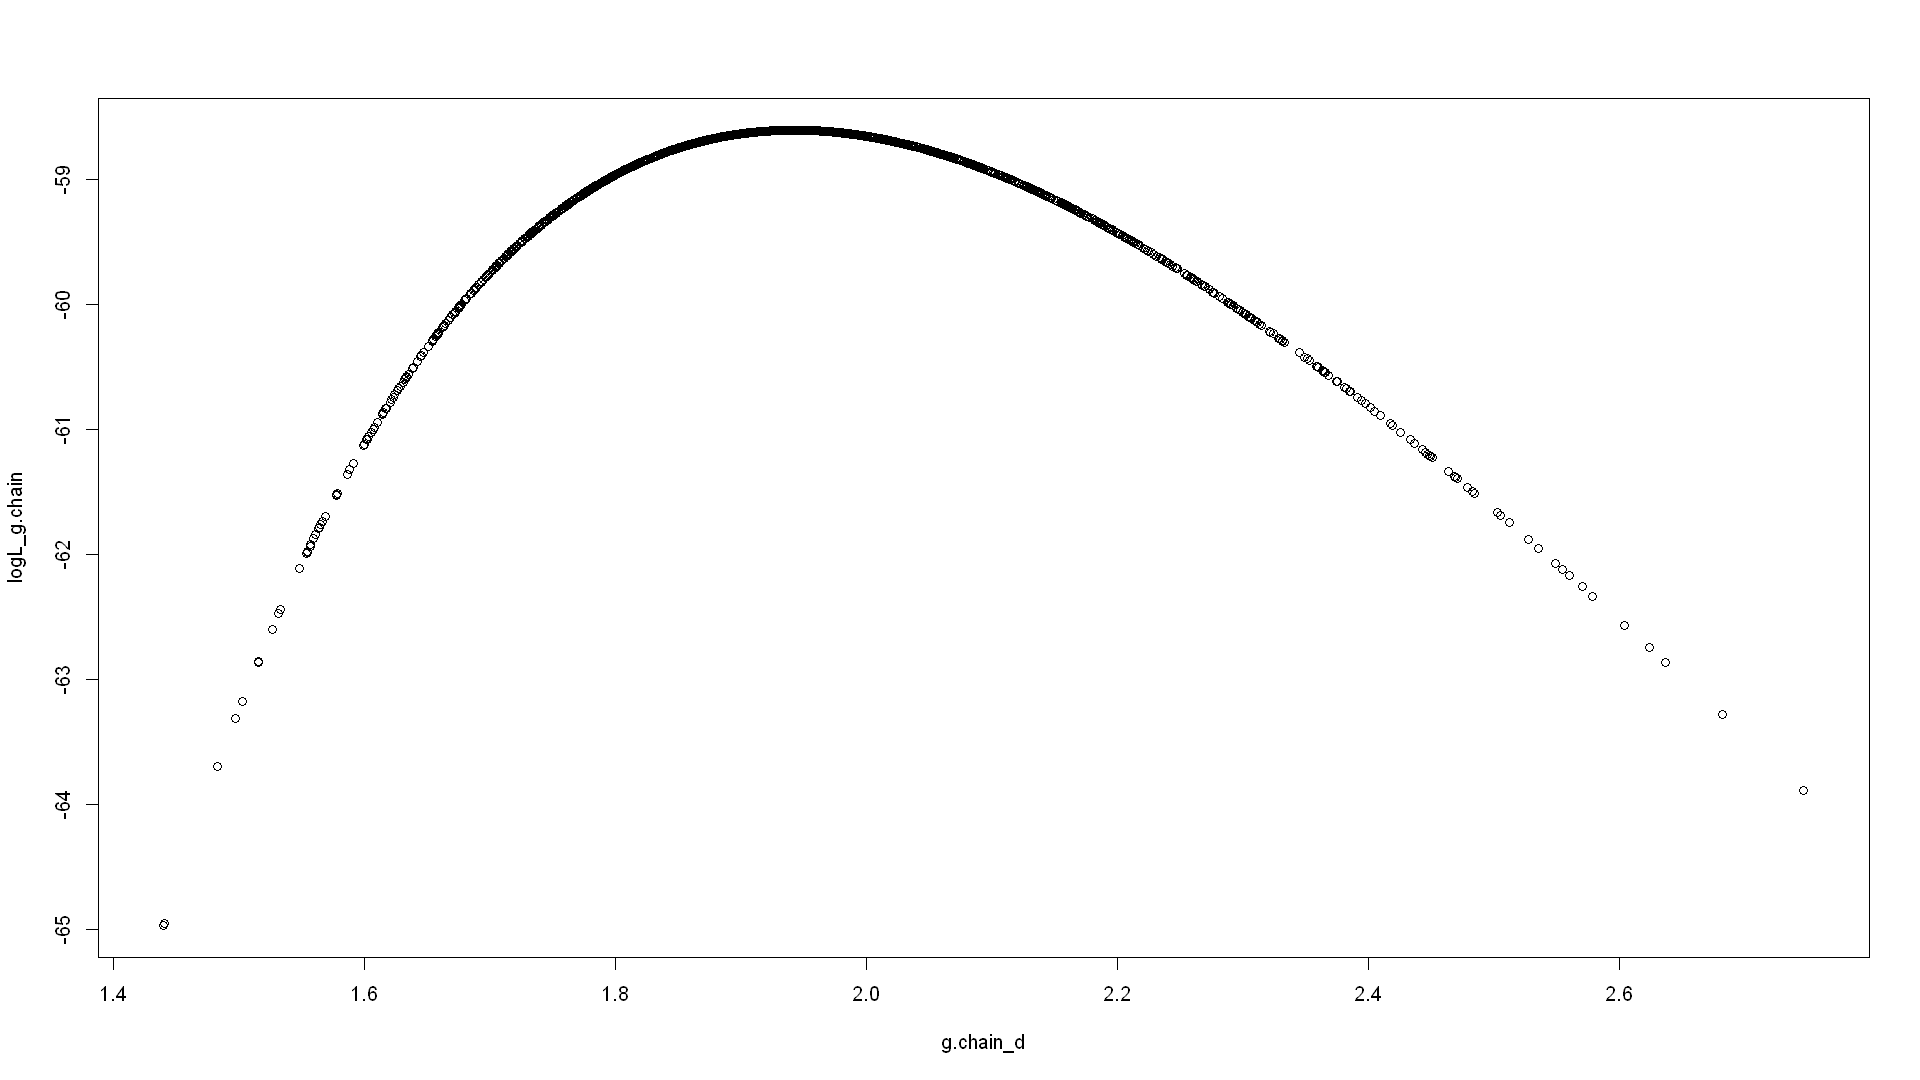

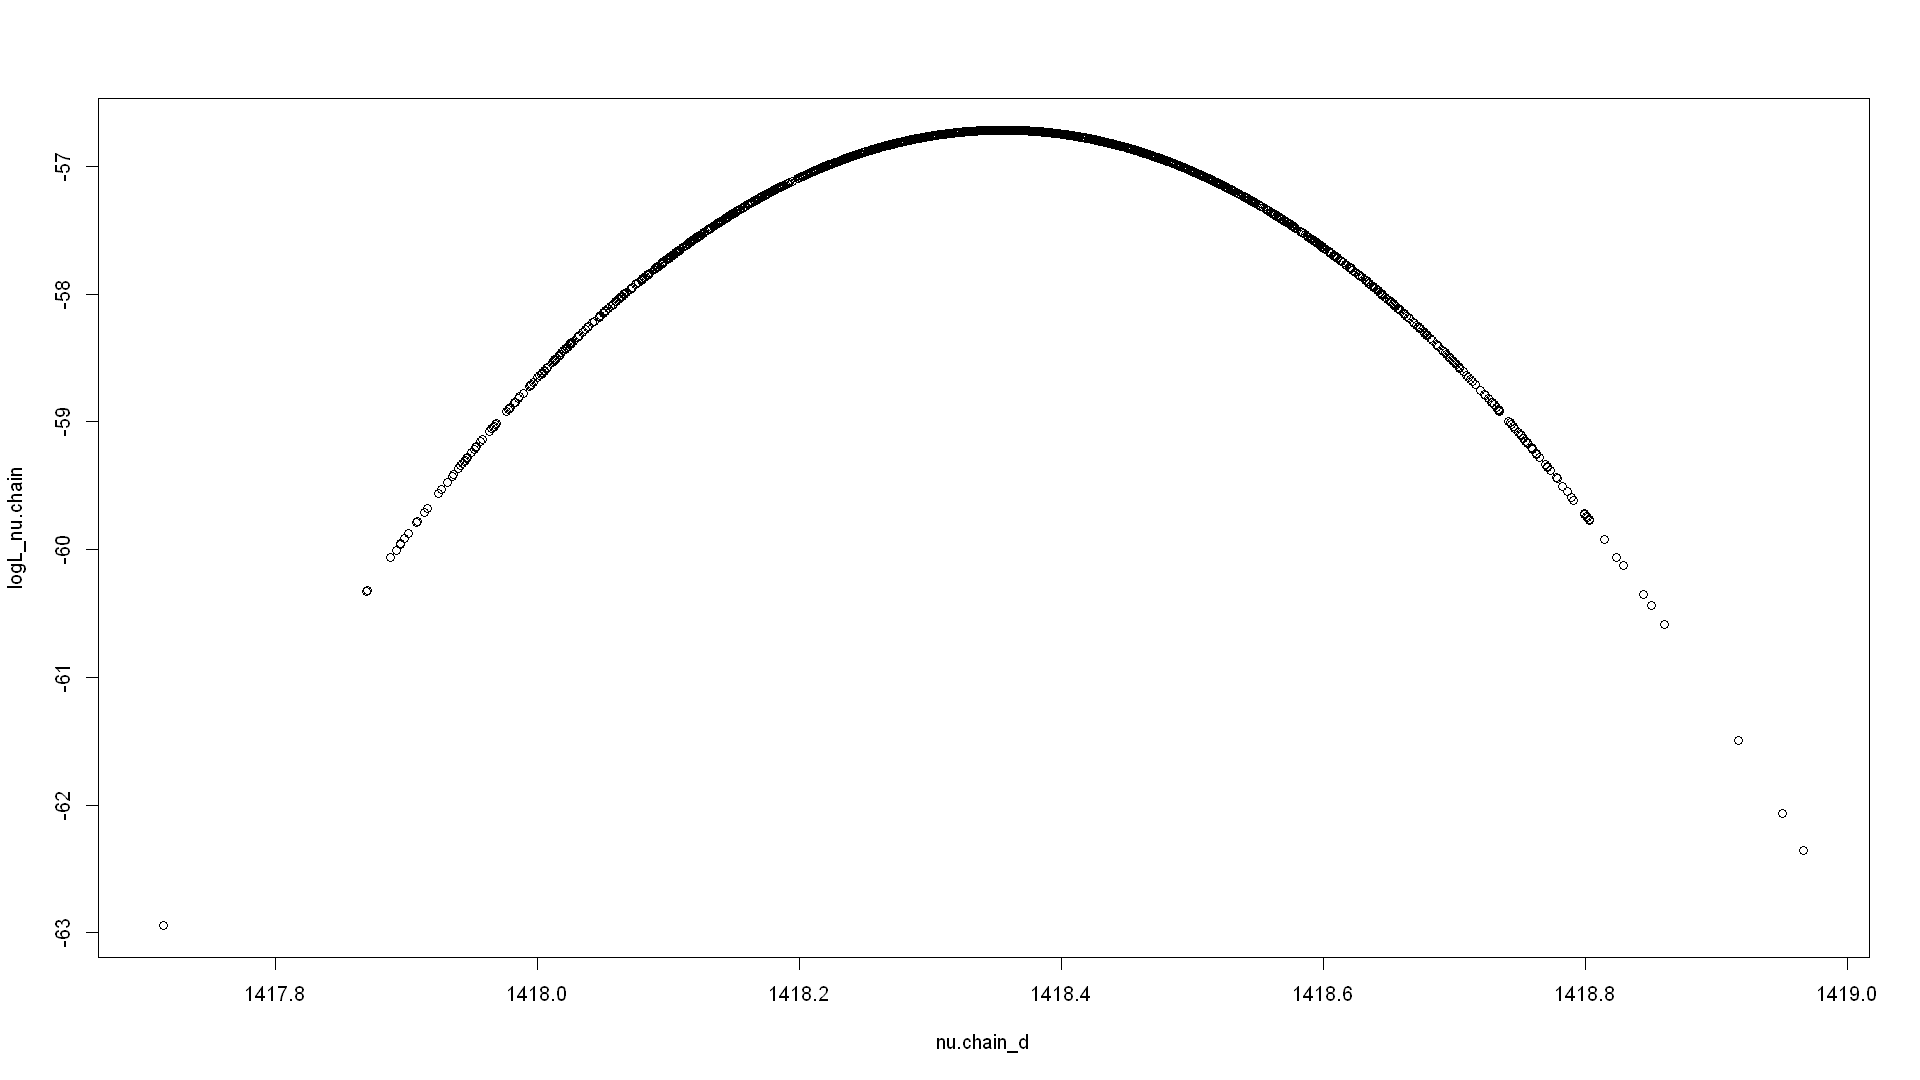

In [27]:
# Some plots
nu.chain_mode = 1418
g.chain_mode = 2

g.chain_d = sort( g.chain_d  , decreasing = FALSE )
logL_g.chain = vec.logL(nu.chain_mode,g.chain_d)
# plot(g.chain_d,logL_g.chain)

nu.chain_d = sort( nu.chain_d , decreasing = FALSE )
logL_nu.chain = vec.logL(nu.chain_d,g.chain_mode)
# plot(nu.chain_d,logL_nu.chain)

logL_chain_d = vec.logL(nu.chain_d,g.chain_d)

In [28]:
logL_mean = sum(logL_chain_d) / length(logL_chain_d)

logL_mean

[1] -57.67573